<a href="https://colab.research.google.com/github/AbhirKarande/OCRandProductRecognition/blob/main/SiameseFewShot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/AbhirKarande/OCRandProductRecognition.git

Cloning into 'OCRandProductRecognition'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 60 (delta 2), reused 0 (delta 0), pack-reused 49
Unpacking objects: 100% (60/60), 5.87 MiB | 9.49 MiB/s, done.


In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

In [3]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

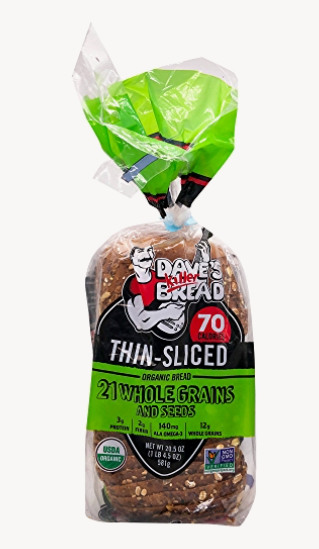

In [4]:
Image.open("/content/OCRandProductRecognition/WholeFoodsTrainingImages/train/Dave's Killer Bread Organic Thin-sliced 21 Whole Grains and Seeds Bread/DavesKiller1.png")

In [5]:
img = read_image("/content/OCRandProductRecognition/WholeFoodsTrainingImages/train/Dave's Killer Bread Organic Thin-sliced 21 Whole Grains and Seeds Bread/DavesKiller1.png")

AttributeError: ignored

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Define the Siamese network architecture
def create_siamese_network(input_shape):
    input_1 = tf.keras.Input(shape=input_shape)
    input_2 = tf.keras.Input(shape=input_shape)

    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = False

    processed_1 = base_model(input_1)
    processed_2 = base_model(input_2)

    flattened_1 = layers.Flatten()(processed_1)
    flattened_2 = layers.Flatten()(processed_2)

    concatenated = layers.Concatenate()([flattened_1, flattened_2])

    dense_1 = layers.Dense(128, activation='relu')(concatenated)
    dense_2 = layers.Dense(64, activation='relu')(dense_1)
    output = layers.Dense(1, activation='sigmoid')(dense_2)

    model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

    return model


In [8]:
# Set the input shape of your images
input_shape = (224, 224, 3)  # Adjust this according to your image dimensions

# Create the Siamese network
siamese_net = create_siamese_network(input_shape)

94765736/94765736 [==============================] - 0s 0us/step


In [9]:
# Compile the model
siamese_net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Create data generators for loading and augmenting the images
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [13]:
train_generator = datagen.flow_from_directory(
    '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/OCRandProductRecognition/WholeFoodsTrainingImages/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 16 images belonging to 4 classes.
Found 4 images belonging to 4 classes.


In [14]:
siamese_net.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


ValueError: ignored